<a href="https://colab.research.google.com/github/Rama389/AI-Projects/blob/main/Supervised_Learning_KNN_ParzenWindow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##KNN and Parzen Window classifiers hyper parameter sweeps

**Brief Summary**:


**KNN Algorithm**:
1. KNN is a Lazy Learning algorithm uses the principle of classifying similar items
2. It calculates the distances with sourrounding points
3. It groups based on the distances
4. It needs hyper parameter 'K'so that it can create groups/classes

Parzen Window:
1. Parzen window uses Probability Density Function(PDF)
2. It uses sigma as hyper parameter
3. Kernal function for defining the shape of the window
4. It works on the principle of how many points fall under a window and then normalizing the count using Bayes theorem



Loading data from tmnst Dataset.csv...
Cleaned data shape: (74724, 784)
Cleaned labels shape: (74724,)
Train data shape before LDA: (52306, 784)
Test data shape before LDA: (22418, 784)

Applying Fisher's LDA to reduce dimensions to 25...
Train data shape after LDA: (52306, 25)
Test data shape after LDA: (22418, 25)

--- Running KNN Hyperparameter Sweep (K_values: [1, 3, 5, 7, 9, 11, 13, 15, 17]) ---
  Testing K = 1...
    Train Acc: 1.0000, Test Acc: 0.9476
  Testing K = 3...
    Train Acc: 0.9693, Test Acc: 0.9440
  Testing K = 5...
    Train Acc: 0.9611, Test Acc: 0.9431
  Testing K = 7...
    Train Acc: 0.9565, Test Acc: 0.9408
  Testing K = 9...
    Train Acc: 0.9536, Test Acc: 0.9397
  Testing K = 11...
    Train Acc: 0.9518, Test Acc: 0.9388
  Testing K = 13...
    Train Acc: 0.9495, Test Acc: 0.9376
  Testing K = 15...
    Train Acc: 0.9481, Test Acc: 0.9369
  Testing K = 17...
    Train Acc: 0.9465, Test Acc: 0.9361

Knn.csv generated successfully.


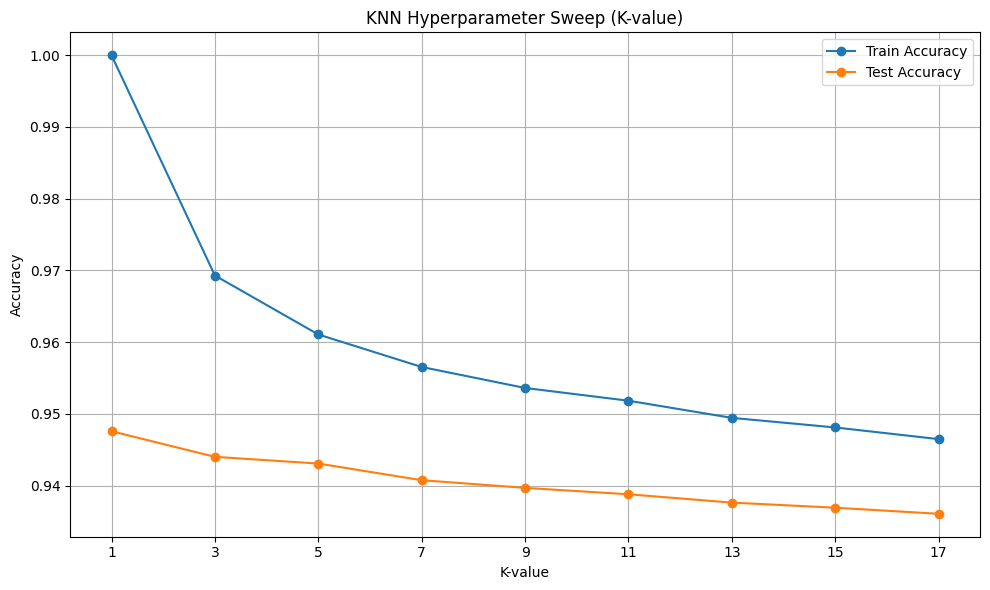


--- Running Optimized Parzen Window (Kernel Density) Sweep (sigma_values: [0.1, 0.5, 1, 1.5, 2, 3, 4, 6, 8, 10]) ---
  Testing Sigma (bandwidth) = 0.1...
    Train Acc: 1.0000, Test Acc: 0.5940
  Testing Sigma (bandwidth) = 0.5...
    Train Acc: 1.0000, Test Acc: 0.9113
  Testing Sigma (bandwidth) = 1...
    Train Acc: 0.9963, Test Acc: 0.9448
  Testing Sigma (bandwidth) = 1.5...
    Train Acc: 0.9764, Test Acc: 0.9336
  Testing Sigma (bandwidth) = 2...
    Train Acc: 0.9417, Test Acc: 0.9160
  Testing Sigma (bandwidth) = 3...
    Train Acc: 0.9009, Test Acc: 0.8935
  Testing Sigma (bandwidth) = 4...
    Train Acc: 0.8902, Test Acc: 0.8842
  Testing Sigma (bandwidth) = 6...
    Train Acc: 0.8843, Test Acc: 0.8762
  Testing Sigma (bandwidth) = 8...
    Train Acc: 0.8824, Test Acc: 0.8736
  Testing Sigma (bandwidth) = 10...
    Train Acc: 0.8812, Test Acc: 0.8727

Parzen.csv generated successfully.


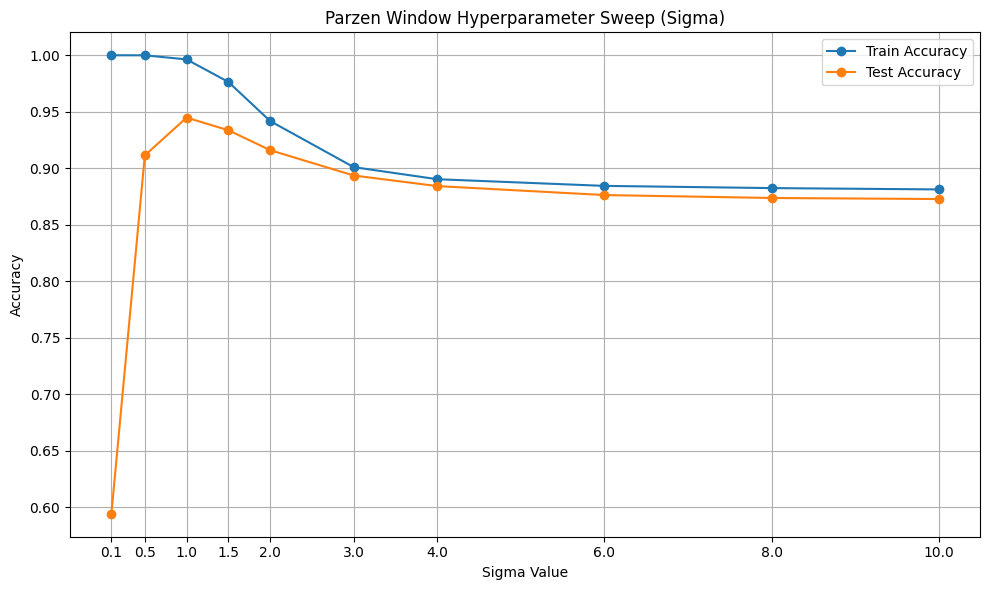


--- Sweeps Completed ---
Check 'Knn.csv', 'Parzen.csv', 'KNN_Sweep_Plot.png', and 'Parzen_Sweep_Plot.png' in your directory.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity # New import for optimized Parzen
import matplotlib.pyplot as plt

# --- Configuration ---
DATA_FILE = 'tmnst Dataset.csv' # Your data file name
TEST_SIZE = 0.3       # 20% for testing, 80% for training
RANDOM_STATE = 42     # For reproducibility of data split and LDA

# KNN Hyperparameters
KNN_K_VALUES = [1, 3, 5, 7, 9, 11, 13, 15, 17]

# Parzen Window (Kernel Density) Hyperparameters
# These sigma values correspond to the bandwidth 'h' in KernelDensity
PARZEN_SIGMA_VALUES = [0.1, 0.5, 1, 1.5, 2, 3, 4, 6, 8, 10]

# --- 1. Data Loading and Preprocessing ---
print(f"Loading data from {DATA_FILE}...")
try:
    # Load the data, skipping the header row
    data = pd.read_csv(DATA_FILE, header=None, skiprows=1)
except FileNotFoundError:
    print(f"Error: The file '{DATA_FILE}' was not found. Please ensure it's in the same directory.")
    exit()

# Separate features (X) and labels (y)
# Assuming the first column is labels and the rest are features
X = data.iloc[:, 1:].values  # Features (all columns except the first)
y = data.iloc[:, 0].values   # Labels (first column)

# Identify and remove rows with NaN in labels
nan_rows = pd.isnull(y)
if np.any(nan_rows):
    print(f"Warning: Found {np.sum(nan_rows)} rows with NaN values in the label column. Removing these rows.")
    X = X[~nan_rows]
    y = y[~nan_rows]

print(f"Cleaned data shape: {X.shape}")
print(f"Cleaned labels shape: {y.shape}")

# Identify and remove classes with only one sample
unique_classes, class_counts = np.unique(y, return_counts=True)
classes_to_keep = unique_classes[class_counts >= 2]
indices_to_keep = np.isin(y, classes_to_keep)

if len(unique_classes) != len(classes_to_keep):
    removed_classes = set(unique_classes) - set(classes_to_keep)
    print(f"Warning: Removing classes with only one sample: {removed_classes}")
    X = X[indices_to_keep]
    y = y[indices_to_keep]
    print(f"Data shape after removing single-sample classes: {X.shape}")
    print(f"Labels shape after removing single-sample classes: {y.shape}")


# Split data into training and testing sets
# stratify=y ensures that the proportion of classes is the same in train and test sets
X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"Train data shape before LDA: {X_train_orig.shape}")
print(f"Test data shape before LDA: {X_test_orig.shape}")

# --- 2. Dimensionality Reduction using Fisher's LDA ---
print("\nApplying Fisher's LDA to reduce dimensions to 25...")
# Linear Discriminant Analysis (LDA) is a supervised dimensionality reduction technique.
# For C classes, LDA can project the data into at most C-1 dimensions.
# Here, we have 26 classes, so n_components=25 is the maximum possible.
# We need to ensure that n_components is less than or equal to n_classes - 1
unique_classes = np.unique(y_train)
n_classes = len(unique_classes)
n_components_lda = min(25, n_classes - 1)

if n_components_lda < 25:
    print(f"Warning: Number of unique classes in training data ({n_classes}) is less than 26. LDA will reduce to {n_components_lda} dimensions.")

lda = LinearDiscriminantAnalysis(n_components=n_components_lda)

# Fit LDA on the training data and transform both train and test data.
# It's crucial to fit LDA only on training data to prevent data leakage.
X_train_lda = lda.fit_transform(X_train_orig, y_train)
X_test_lda = lda.transform(X_test_orig)

print(f"Train data shape after LDA: {X_train_lda.shape}")
print(f"Test data shape after LDA: {X_test_lda.shape}")

# --- 3. KNN Hyperparameter Sweep Function ---

def knn_sweep(train_features, train_labels, test_features, test_labels, K_values):
    """
    Performs a hyperparameter sweep for K-Nearest Neighbors (KNN) classifier.

    Args:
        train_features (np.array): Training data features (25-D).
        train_labels (np.array): Training data labels.
        test_features (np.array): Test data features (25-D).
        test_labels (np.array): Test data labels.
        K_values (list): List of K values to test.

    Returns:
        pd.DataFrame: DataFrame containing K-value, train accuracy, and test accuracy.
    """
    print(f"\n--- Running KNN Hyperparameter Sweep (K_values: {K_values}) ---")
    results = []

    for k in K_values:
        print(f"  Testing K = {k}...")
        # Initialize KNN classifier with the current K value
        knn = KNeighborsClassifier(n_neighbors=k)
        # Fit the KNN model. For KNN, fitting means storing the training data.
        knn.fit(train_features, train_labels)

        # Predict labels for the training set and calculate accuracy
        y_train_pred = knn.predict(train_features)
        train_accuracy = accuracy_score(train_labels, y_train_pred)

        # Predict labels for the test set and calculate accuracy
        y_test_pred = knn.predict(test_features)
        test_accuracy = accuracy_score(test_labels, y_test_pred)

        # Store the results for the current K
        results.append({'k-value': k, 'train-accuracy': train_accuracy, 'test-accuracy': test_accuracy})
        print(f"    Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    # Convert results to a Pandas DataFrame and save to CSV
    df_results = pd.DataFrame(results)
    df_results.to_csv('Knn.csv', index=False)
    print("\nKnn.csv generated successfully.")
    return df_results

# --- 4. Optimized Parzen Window (Kernel Density) Classification Sweep Function ---

def parzen_sweep(train_features, train_labels, test_features, test_labels, sigma_values):
    """
    Performs a hyperparameter sweep for Parzen Window (Kernel Density) classifier.
    This implementation uses sklearn.neighbors.KernelDensity for efficiency.

    Args:
        train_features (np.array): Training data features (25-D).
        train_labels (np.array): Training data labels.
        test_features (np.array): Test data features (25-D).
        test_labels (np.array): Test data labels.
        sigma_values (list): List of sigma (bandwidth) values to test.

    Returns:
        pd.DataFrame: DataFrame containing sigma-value, train accuracy, and test accuracy.
    """
    print(f"\n--- Running Optimized Parzen Window (Kernel Density) Sweep (sigma_values: {sigma_values}) ---")
    results = []

    # Get unique classes and their counts to calculate class priors
    unique_classes, class_counts = np.unique(train_labels, return_counts=True)
    class_priors = class_counts / len(train_labels)
    class_to_idx = {cls: i for i, cls in enumerate(unique_classes)}

    for s in sigma_values:
        print(f"  Testing Sigma (bandwidth) = {s}...")

        # Train a KernelDensity model for each class
        kde_models = {}
        for cls in unique_classes:
            # Select training data points belonging to the current class
            X_train_cls = train_features[train_labels == cls]
            if len(X_train_cls) > 0:
                # Initialize KernelDensity with Gaussian kernel and current bandwidth (sigma)
                # 'bandwidth' parameter in KernelDensity corresponds to 'sigma'
                kde = KernelDensity(kernel='gaussian', bandwidth=s)
                kde.fit(X_train_cls)
                kde_models[cls] = kde
            else:
                kde_models[cls] = None # No training data for this class

        # Function to predict for a batch of samples
        def predict_proba_batch(X_data, models, classes, priors, class_map):
            n_samples = X_data.shape[0]
            log_likelihoods = np.full((n_samples, len(classes)), -np.inf) # Initialize with negative infinity

            for cls in classes:
                if models[cls] is not None:
                    # Calculate log-likelihoods p(x|C_i) for all samples in X_data
                    # score_samples returns the log-likelihood of each sample under the model
                    log_likelihoods[:, class_map[cls]] = models[cls].score_samples(X_data)
                # If a class has no model (no training data), its log-likelihood remains -inf

            # Add log-priors: log(P(C_i|x)) = log(P(x|C_i)) + log(P(C_i)) - log(P(x))
            # We only need to compare log(P(x|C_i)) + log(P(C_i)) for classification
            log_priors = np.log(priors)
            log_posterior_unnormalized = log_likelihoods + log_priors

            # Predict the class with the highest unnormalized log-posterior
            # np.argmax will handle -inf correctly, choosing the first valid class if multiple are -inf
            predictions_idx = np.argmax(log_posterior_unnormalized, axis=1)
            return np.array([classes[idx] for idx in predictions_idx])


        # Predict and calculate accuracy for training set
        y_train_pred = predict_proba_batch(X_train_lda, kde_models, unique_classes, class_priors, class_to_idx)
        train_accuracy = accuracy_score(train_labels, y_train_pred)

        # Predict and calculate accuracy for test set
        y_test_pred = predict_proba_batch(X_test_lda, kde_models, unique_classes, class_priors, class_to_idx)
        test_accuracy = accuracy_score(test_labels, y_test_pred)

        # Store the results for the current sigma
        results.append({'sigma-value': s, 'train-accuracy': train_accuracy, 'test-accuracy': test_accuracy})
        print(f"    Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    # Convert results to a Pandas DataFrame and save to CSV
    df_results = pd.DataFrame(results)
    df_results.to_csv('Parzen.csv', index=False)
    print("\nParzen.csv generated successfully.")
    return df_results


# --- Main Execution ---

# Perform KNN Sweep using the LDA-transformed data
knn_results_df = knn_sweep(X_train_lda, y_train, X_test_lda, y_test, KNN_K_VALUES)

# Plot KNN Results
plt.figure(figsize=(10, 6))
plt.plot(knn_results_df['k-value'], knn_results_df['train-accuracy'], marker='o', label='Train Accuracy')
plt.plot(knn_results_df['k-value'], knn_results_df['test-accuracy'], marker='o', label='Test Accuracy')
plt.title('KNN Hyperparameter Sweep (K-value)')
plt.xlabel('K-value')
plt.ylabel('Accuracy')
plt.xticks(KNN_K_VALUES) # Ensure all K values are shown on x-axis
plt.grid(True)
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.savefig('KNN_Sweep_Plot.png') # Save the plot
plt.show() # Display the plot

# Perform Parzen Sweep using the LDA-transformed data
parzen_results_df = parzen_sweep(X_train_lda, y_train, X_test_lda, y_test, PARZEN_SIGMA_VALUES)

# Plot Parzen Results
plt.figure(figsize=(10, 6))
plt.plot(parzen_results_df['sigma-value'], parzen_results_df['train-accuracy'], marker='o', label='Train Accuracy')
plt.plot(parzen_results_df['sigma-value'], parzen_results_df['test-accuracy'], marker='o', label='Test Accuracy')
plt.title('Parzen Window Hyperparameter Sweep (Sigma)')
plt.xlabel('Sigma Value')
plt.ylabel('Accuracy')
plt.xticks(PARZEN_SIGMA_VALUES) # Ensure all Sigma values are shown on x-axis
plt.grid(True)
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.savefig('Parzen_Sweep_Plot.png') # Save the plot
plt.show() # Display the plot

print("\n--- Sweeps Completed ---")
print("Check 'Knn.csv', 'Parzen.csv', 'KNN_Sweep_Plot.png', and 'Parzen_Sweep_Plot.png' in your directory.")

**Comments**:

KNN Method:
At k=1 accuracy is very high but this wll be an over fitting condition so K=1 should not be considered and as K value increasing the accuracy value is decreasing the optimal value of K will be K=3 with 94.40%.

Parzen Window:For the kernal density of Sigma = 1 has the maximum accuracy of 94.48% and as the sigma value increases the more data points will be added to window and the accuracy will be decreased.